普通のDNNでwightが直交行列になるかをconditional numberを用いて観察する。

In [1]:
from __future__ import division

import time
import gzip

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

import TN_utils
reload(TN_utils)
plt.set_cmap("gray")
plt.rcParams["image.interpolation"] = None

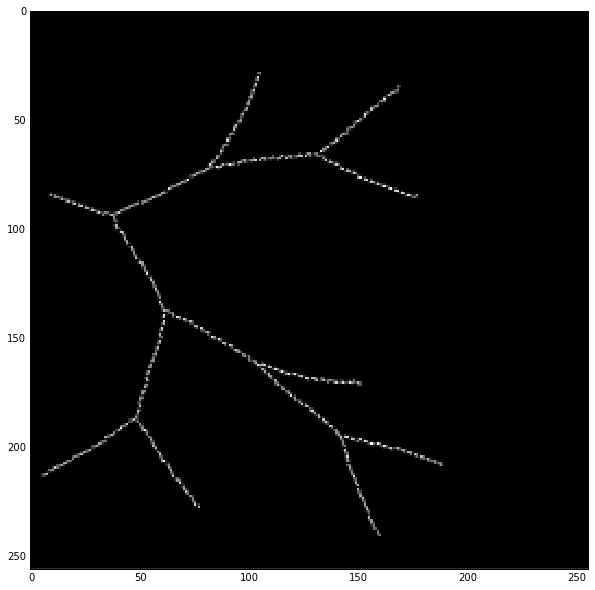

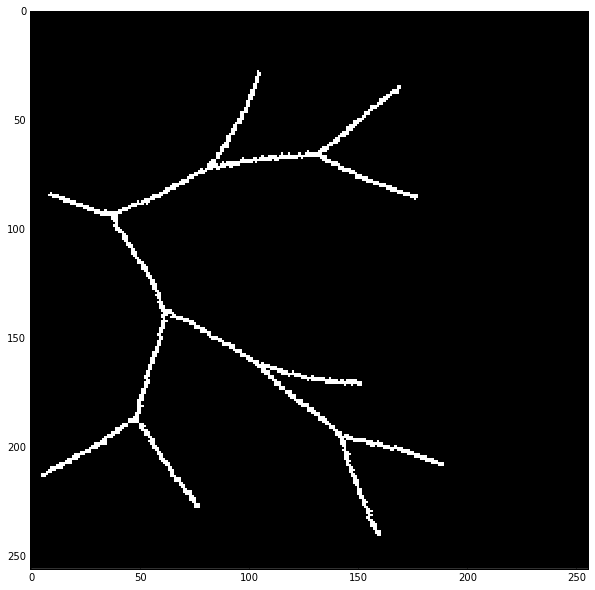

In [2]:
with gzip.open("../data/toytreerot_imgGT.npy.gz") as f:
    imGT_list = np.load(f)
imGT_list.shape
plt.figure(figsize=(10, 10))
plt.imshow(np.linalg.norm(imGT_list[6], axis=1).reshape(256, 256))
for i in range(len(imGT_list)):
    index = np.linalg.norm(imGT_list[i], axis=1).nonzero()[0]
    imGT_list[i][index] = imGT_list[i][index] / np.linalg.norm(imGT_list[i], axis=1)[index][:, np.newaxis]
plt.figure(figsize=(10, 10))
plt.imshow(np.linalg.norm(imGT_list[6], axis=1).reshape(256, 256))

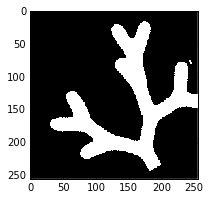

In [3]:
with gzip.open("../data/toytreerot_mask.npy.gz") as f:
    mask_list = np.load(f)
mask_list.shape
plt.figure(figsize=(3, 3))
plt.imshow(mask_list[20].reshape(256, 256))

In [4]:
featureImg_list = []
for i in range(1, 37):
    print i
    matlab_struct = sio.loadmat('../data/featureImgr' + str(i) + '.mat')
    featureImg = matlab_struct['f']

    # 複素数からベクトルへの変換
    featureImg_vec = np.zeros((featureImg.shape[0], 12, 2))
    featureImg_vec[:, :, 0] = np.real(featureImg[:, 12:24])
    featureImg_vec[:,:,1] = np.imag(featureImg[:, 12:24])
    featureImg_list.append(featureImg_vec)

print featureImg.dtype, featureImg_list[1].shape

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
complex128 (65536, 12, 2)


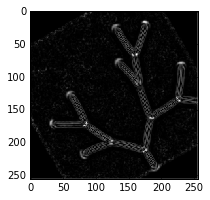

In [5]:
plt.figure(figsize=(3, 3))
plt.imshow(np.linalg.norm(featureImg_list[20][:, 5], axis=1).reshape(256, 256))

In [6]:
m_featureImg_list = [featureImg_list[i][mask_list[i]] for i in range(36)]
m_imgGT_list = [imGT_list[i][mask_list[i]] for i in range(36)]

In [7]:
m_feature_t1 = m_featureImg_list[0]
m_GT_t1 = m_imgGT_list[0]
m_feature_t1.shape, m_GT_t1.shape

((13857, 12, 2), (13857, 2))

In [8]:
range(0, 36, 3)

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33]

In [9]:
# 10, 40, 70, 130, ...340の12サンプル
m_feature_t12 = np.concatenate([m_featureImg_list[i] for i in range(0, 36, 4)], axis=0)
m_GT_t12 = np.concatenate([m_imgGT_list[i] for i in range(0, 36, 4)], axis=0)
print m_feature_t12.shape, m_GT_t12.shape

(124755, 12, 2) (124755, 2)


In [10]:
m_feature_t36 = np.concatenate([m_featureImg_list[i] for i in range(0, 11) + range(12, 36)], axis=0)
m_GT_t36 = np.concatenate([m_imgGT_list[i] for i in range(0, 11) + range(12, 36)], axis=0)
print m_feature_t36.shape, m_GT_t36.shape

(485423, 12, 2) (485423, 2)


In [11]:
m_feature_vec120 = m_featureImg_list[11]
m_GT_vec120 = m_imgGT_list[11]

In [35]:
activation_list = ["ReLU", "ReLU"]
n_tensors = 12
dim = 2
n_hidden = 20
param_list = [0.01 * np.random.normal(size=(n_tensors*dim, n_hidden)), np.zeros(n_hidden//2),
              0.01 * np.random.normal(size=(n_hidden, dim)), np.zeros(1)]

In [36]:
n_hidden//2

10

In [44]:
import theano_dnn
reload(theano_dnn)

<module 'theano_dnn' from 'theano_dnn.py'>

In [45]:
vnn = theano_dnn.VnnClf(m_feature_t1, m_GT_t1,
                         m_feature_vec120, m_GT_vec120,
                         param_list, ["w1", "b1", "w2", "b2"], activation_list, vector_activation_shape_list=[2, 2])

In [46]:
vnn.initialize_params(param_list)

In [47]:
feature_list =[m_feature_t1, m_feature_t12, m_feature_t36]
GT_list = [m_GT_t1, m_GT_t12, m_GT_t36]
epoch_list = [2160, 180, 60]
lr_list = [0.005, 0.005, 0.005]

In [48]:

vnn.set_training(feature_list[1], GT_list[1]) 

In [49]:
batch_size = 100
l2 = 0.

n_batchs = vnn.n_pixels // batch_size
        
n_epochs = epoch_list[1]
interval = n_epochs // 30
training_MSE_array = np.zeros(n_epochs // interval)
test_MSE_array = np.zeros(n_epochs // interval)

In [50]:
cn_list_list = []
weighted_sum_list = []
lr = lr_list[1]
for i_epoch in xrange(n_epochs):
    for i_batch in xrange(n_batchs):
        vnn.train(i_batch, lr, l2, batch_size)

    if i_epoch % interval == 0:
        MSE = vnn.training_error()
        training_MSE_array[i_epoch // interval] = MSE
        MSE = vnn.test_error()
        test_MSE_array[i_epoch // interval] = MSE

        w_list = vnn.get_w_list()
        cn_list = []
        for aw in w_list:
            cn_list.append(TN_utils.clcl_cn_inv(aw))
        cn_list_list.append(cn_list)
        w_norm_list = np.asarray([np.sum(w**2) for w in w_list])
        weighted_sum = np.sum(np.asarray(cn_list) * np.asarray(w_norm_list))
        n_weighted_sum = weighted_sum / np.sum(w_norm_list)
        weighted_sum_list.append(n_weighted_sum)

        print i_epoch, MSE

0 0.041020576013
6 0.0134561756493
12 0.0133725422147
18 0.0133316550612
24 0.0133032060892
30 0.0132801682657
36 0.0132605945785
42 0.0132400195702
48 0.0132204593834
54 0.0132028241908
60 0.0131811842163
66 0.0131582898301
72 0.0131368505032
78 0.0131452083279
84 0.0130991328968
90 0.0130697233447
96 0.0130494860431
102 0.0130295758355
108 0.0130022759132
114 0.0129904773188
120 0.0129705079806
126 0.0129691739757
132 0.0129546180268
138 0.0129440550858
144 0.0129178664243
150 0.0129054078598
156 0.0128985796166
162 0.0128676328101
168 0.0128532667676
174 0.0128188001468


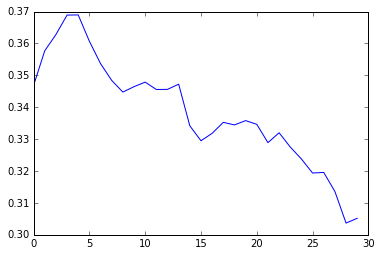

In [51]:
plt.plot(np.mean(cn_list_list, axis=1))

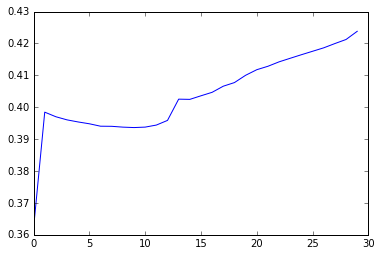

In [52]:
# まじか
plt.plot(weighted_sum_list)

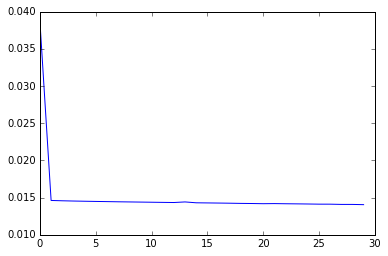

In [53]:
plt.plot(training_MSE_array)

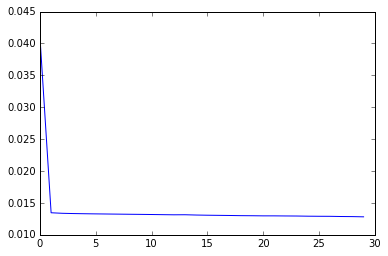

In [54]:
plt.plot(test_MSE_array)

In [55]:
import cond_num_dnn_ex
reload(cond_num_dnn_ex)

<module 'cond_num_dnn_ex' from 'cond_num_dnn_ex.pyc'>

In [58]:
feature_list =[m_feature_t1, m_feature_t12, m_feature_t36]
GT_list = [m_GT_t1, m_GT_t12, m_GT_t36]
epoch_list = [2160, 180, 60]
lr_list = [0.0005, 0.0005, 0.0005]

In [59]:
results = cond_num_dnn_ex.cond_num_dnn_ex(vnn, param_list, feature_list, GT_list, 
                                          lr_list, epoch_list, featureImg_list)

0 0.0528851556667
144 0.0283565363451
288 0.0143402875869
432 0.0135281213161
576 0.0134552696215
720 0.0134333179648


ValueError: array must not contain infs or NaNs

In [37]:
train_error_list, test_error_list, cn11236, wsc11236, gt1img360_list, gt1img120_list = results

In [38]:
namelist = ["train_error_list", "test_error_list", "cn11236", "wsc11236", "gt1img360_list", "gt1img120_list"]
for data, name in zip(results, namelist):
    with gzip.open("../results/CondNumDNN_biasedReLU/"+name+".npy.gz", "w") as f:
        np.save(f, data)

In [39]:
sio.savemat('../results/CondNumDNN_biasedReLU/v_train360_list.mat', {'v_train360_list': gt1img360_list})
sio.savemat('../results/CondNumDNN_biasedReLU/v_train120_list.mat', {'v_train120_list': gt1img120_list})

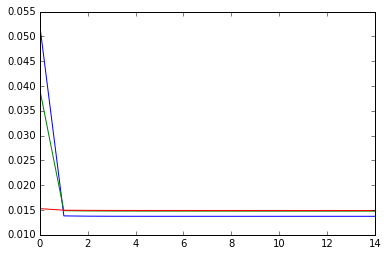

In [40]:
for i in range(3):    
    plt.plot(train_error_list[i])

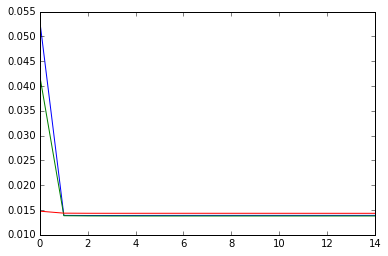

In [41]:
for i in range(3): 
    plt.plot(test_error_list[i])

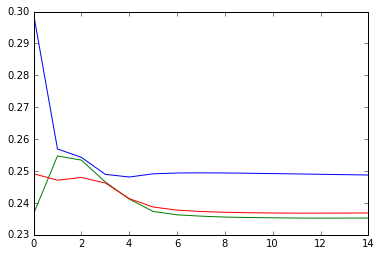

In [42]:
for i in range(3):
    plt.plot(np.mean(cn11236[i], axis=1))

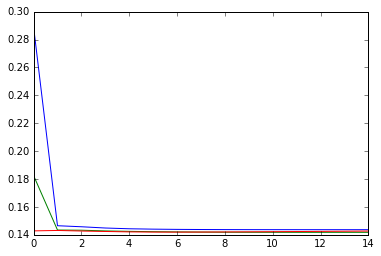

In [43]:
for i in range(3):    
    plt.plot(wsc11236[i])

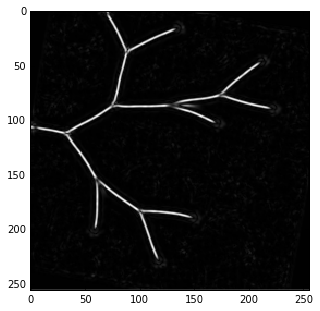

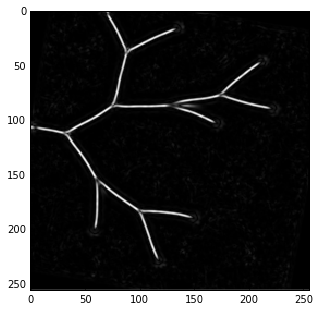

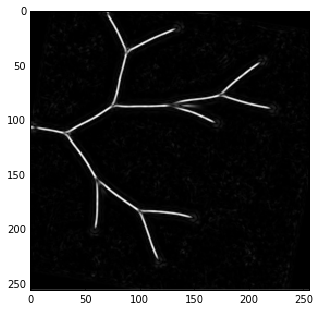

In [44]:
for i in range(3):
    plt.figure(figsize=(5, 5))
    plt.imshow(np.linalg.norm(gt1img360_list[i], axis=0))

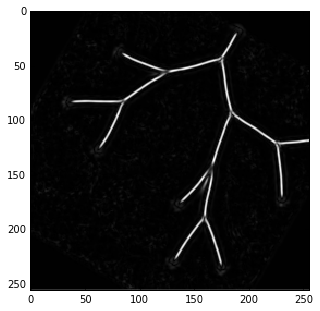

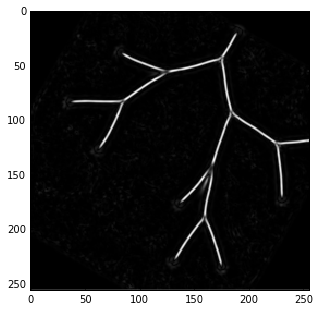

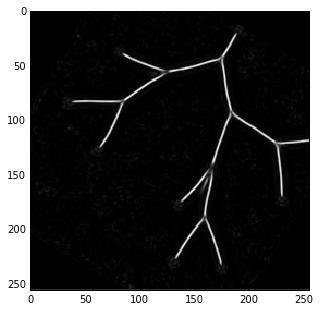

In [45]:
for i in range(3):
    plt.figure(figsize=(5, 5))
    plt.imshow(np.linalg.norm(gt1img120_list[i], axis=0))